In [ ]:
import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')

import scanpy as sc
import time 
import os.path as op
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import scipy.sparse as scs

import torch
import yaml


from netmap.src.utils.misc import write_config


from netmap.src.utils.data_utils import *
from netmap.src.utils.tf_utils import *
from netmap.src.utils.netmap_config import NetmapConfig

from netmap.src.model.train_model import create_model_zoo
from netmap.src.grn.inferrence import inferrence
from src.data_simulation.data_simulation_config import DataSimulationConfig
from netmap.src.masking.internal import *
from netmap.src.masking.external import *

def read_config(file):
    with open(file, "r") as f:
        config = yaml.safe_load(f)
    return config





In [ ]:



#config = NetmapConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/config/perturb_seq/")
dada = "/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_172_54892_net_131_54992_net_158_55084.config.yaml"
dataset_config = read_config("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_172_54892_net_131_54992_net_158_55084.config.yaml")

nets = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['edgelist']]
common = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['common_edges']]

    
config = NetmapConfig.read_yaml('/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_1/config_easy/net_172_54892_net_131_54992_net_158_55084/config.yaml')
dataset_config = DataSimulationConfig.read_yaml(dada)



start_total = time.monotonic()

## Load config and setup outputs
os.makedirs(config.output_directory, exist_ok=True)
sc.settings.figdir = config.output_directory
config.write_yaml(yaml_file=op.join(config.output_directory, 'config.yaml'))

## load data
adata = sc.read_h5ad(config.input_data)


## Get the data matrix from the CustumAnndata obeject
gene_names = np.array(adata.var.index)
model_start = time.monotonic()

if config.layer == 'counts':
    data_tensor = adata.layers['counts']
else:
    data_tensor = adata.X

if scs.issparse(data_tensor):
    data_tensor = torch.tensor(data_tensor.todense(), dtype=torch.float32)
else:
    data_tensor = torch.tensor(data_tensor, dtype=torch.float32)


NameError: name 'read_config' is not defined

In [3]:
model_zoo = create_model_zoo(data_tensor,  n_models=config.n_models, n_epochs=config.epochs, model_type=config.model)

grn_adata = inferrence(model_zoo, data_tensor.cuda(), gene_names,  config, use_raw_attribution=False)
grn_adata_raw = inferrence(model_zoo, data_tensor.cuda(), gene_names,  config, use_raw_attribution=True)
grn_adata.layers['raw_attribution'] = grn_adata_raw.X
grn_adata.layers['raw_attribution_quantile_count'] = grn_adata_raw.layers['quantile_count']

grn_adata = add_neighbourhood_expression_mask(adata,grn_adata)

KeyboardInterrupt: 

In [8]:
grn_adata

AnnData object with n_obs × n_vars = 1000 × 212521
    var: 'source', 'target'
    layers: 'quantile_count', 'raw_attribution', 'raw_attribution_quantile_count', 'mask'

In [ ]:

pariwise_consistency_1 = find_consistent_pairs(grn_adata[grn_adata.obs['grn'] == 1.0, :].copy(), gene_names)
pariwise_consistency_2 = find_consistent_pairs(grn_adata[grn_adata.obs['grn'] == 2.0, :].copy(), gene_names)

In [ ]:
pairwise_consistency_1 = pd.DataFrame(pariwise_consistency_1.items())
pairwise_consistency_2 = pd.DataFrame(pariwise_consistency_2.items())

In [ ]:
pairwise_consistency_1.columns = ['edge', 'spearman']
pairwise_consistency_2.columns = ['edge', 'spearman']



In [4]:
def get_top_edges_per_cell(grn_adata, top_edges):
    
    idex = grn_adata.shape[1]-top_edges
    b = np.argpartition(grn_adata.X, idex, axis=1)    # top 3 values from each row
    top_idx = b[:,idex:]


    scgenerai_var_index_np = np.array(grn_adata.var)
    top_edges_per_cell = pd.DataFrame(np.concat(scgenerai_var_index_np[top_idx]))
    top_edges_per_cell.columns = ['source', 'target', 'n_cells']
    top_edges_per_cell['cell_barcode'] = np.repeat(grn_adata.obs.index, repeats=top_edges)
    return top_edges_per_cell





In [5]:
import scanpy as sc

In [ ]:
grn_ad = sc.read_h5ad('/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_4/config_easy/net_63_54572_net_51_55200_net_94_55257/grn_lrp.h5ad')

In [ ]:
grn_adata_sub = sc.get.aggregate(grn_ad,by='grn', func=['mean'])


In [7]:
df = pd.DataFrame(grn_ad.layers['quantile_count'])/20

In [8]:
import pandas as pd

In [9]:
grn_ad.obs['grn'] = pd.Categorical(grn_ad.obs['grn'] )

In [10]:
sc.tl.rank_genes_groups(grn_ad, layer='quantile_count', groupby='grn', use_raw=False)

In [4]:

#config = NetmapConfig.read_yaml("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/netmap/config/perturb_seq/")
dada = "/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_63_54572_net_51_55200_net_94_55257.config.yaml"
dataset_config = read_config("/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_easy/net_63_54572_net_51_55200_net_94_55257.config.yaml")

nets = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['edgelist']]
common = [pd.read_csv(op.join("/data_nfs/og86asub/netmap/netmap-evaluation/data/clustered_network/", filename), sep='\t') for filename in dataset_config['common_edges']]


NameError: name 'read_config' is not defined

In [12]:
df = sc.get.rank_genes_groups_df(grn_ad, group = '2.0')

In [13]:
df[['source', 'target']] = df['names'].str.split('_', expand=True)

In [14]:
df[ (np.abs(df['logfoldchanges'])>6)].merge(nets[0], left_on = ['source', 'target'], right_on=['target', 'source'])

,names,scores,logfoldchanges,pvals,pvals_adj,source_x,target_x,source_y,target_y
0,CDH1_SATB2,-34.640,-6.350,0.000,0.000,CDH1,SATB2,SATB2,CDH1
1,TWIST1_SNAI1,-35.908,-6.326,0.000,0.000,TWIST1,SNAI1,SNAI1,TWIST1
2,CDH1_HOXA7,-38.957,-8.477,0.000,0.000,CDH1,HOXA7,HOXA7,CDH1
3,CDH1_MEIS2,-39.728,-8.958,0.000,0.000,CDH1,MEIS2,MEIS2,CDH1
4,CDH1_SNAI1,-42.468,-8.828,0.000,0.000,CDH1,SNAI1,SNAI1,CDH1
...,...,...,...,...,...,...,...,...,...
97,CD24_TWIST2,-239.912,-16.256,0.000,0.000,CD24,TWIST2,TWIST2,CD24
98,CD44_KLF17,-242.340,-12.188,0.000,0.000,CD44,KLF17,KLF17,CD44
99,PCGF2_ZEB1,-244.127,-10.266,0.000,0.000,PCGF2,ZEB1,ZEB1,PCGF2
100,FN1_KLF8,-279.359,-13.498,0.000,0.000,FN1,KLF8,KLF8,FN1


array([[<Axes: title={'center': '0'}>]], dtype=object)

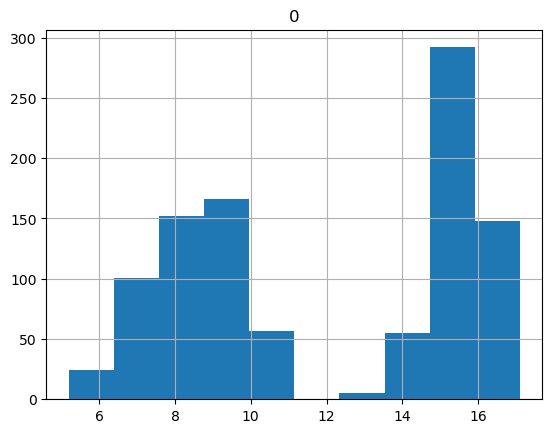

In [15]:
pd.DataFrame(grn_ad[:, grn_ad.var.index == 'SNAI2_CLDN1'].layers['quantile_count']).hist()

In [3]:
config = NetmapConfig.read_yaml('/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_4/config_easy/net_63_54572_net_51_55200_net_94_55257/config.yaml')
dataset_config = DataSimulationConfig.read_yaml(dada)

adata = sc.read_h5ad(config.input_data)


NameError: name 'NetmapConfig' is not defined

In [89]:
grn_ad.X

array([[ 0.02228675, -0.02603092,  0.02731722, ...,  0.00365057,
        -0.00170965,  0.00662093],
       [ 0.01951803, -0.02421681,  0.02663702, ...,  0.00288517,
        -0.00124652,  0.00512633],
       [ 0.01927936, -0.02426149,  0.02522032, ...,  0.00257304,
        -0.00118965,  0.00721397],
       ...,
       [ 0.0069217 ,  0.00538674,  0.01354347, ...,  0.00296228,
        -0.00015939,  0.00760652],
       [ 0.00598482,  0.00636086,  0.01334497, ...,  0.00272086,
        -0.00050106,  0.00810902],
       [ 0.00730432,  0.00766304,  0.01343963, ...,  0.00261679,
         0.00098754,  0.00695201]], shape=(1000, 43264), dtype=float32)

array([[<Axes: title={'center': '0'}>]], dtype=object)

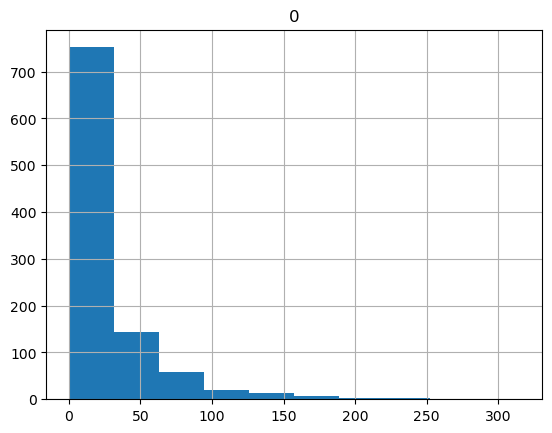

In [17]:
pd.DataFrame(adata[:, adata.var.index == 'KRT19'].X).hist()

In [18]:
def find_consistent_pairs(grn_adata, gene_names):
    """
    Creates a dictionary of binary masks for each cell and pair of genes,
    including both forward, reverse, and self-pairs (which are all zeros).

    Args:
        matrix_cells_x_genes (np.ndarray): A 2D numpy array where rows are cells
                                          and columns are genes.
        gene_list (list): A list of strings containing the names of the genes,
                          in the same order as the columns in the matrix.

    Returns:
        dict: A dictionary where keys are gene pair strings (e.g., 'GeneA_GeneB')
              and values are 1D numpy arrays representing the binary mask for that pair
              across all cells.
    """

    num_cells, num_edges = grn_adata.X.shape

    pairwise_mask_dict = {}

    gene_pairs_indices = list(itertools.combinations(gene_names, 2))
    for g1_idx, g2_idx in gene_pairs_indices:
        pairwise_mask_dict[f"{g1_idx}_{g2_idx}"] = st.spearmanr(grn_adata[:, [f"{g1_idx}_{g2_idx}", f"{g2_idx}_{g1_idx}"]].X).statistic
        # add reverse bc I am lazy
        pairwise_mask_dict[f"{g2_idx}_{g1_idx}"] = pairwise_mask_dict[f"{g1_idx}_{g2_idx}"]
    return pairwise_mask_dict

In [132]:
def average_edges(grn_adata, gene_names):
    """
    Creates a dictionary of binary masks for each cell and pair of genes,
    including both forward, reverse, and self-pairs (which are all zeros).

    Args:
        matrix_cells_x_genes (np.ndarray): A 2D numpy array where rows are cells
                                          and columns are genes.
        gene_list (list): A list of strings containing the names of the genes,
                          in the same order as the columns in the matrix.

    Returns:
        dict: A dictionary where keys are gene pair strings (e.g., 'GeneA_GeneB')
              and values are 1D numpy arrays representing the binary mask for that pair
              across all cells.
    """

    num_cells, num_edges = grn_adata.X.shape

    pairwise_mask_dict = {}

    gene_pairs_indices = list(itertools.combinations(gene_names, 2))
    for g1_idx, g2_idx in gene_pairs_indices:
        pairwise_mask_dict[f"{g1_idx}_{g2_idx}"] = np.mean(grn_adata[:, [f"{g1_idx}_{g2_idx}", f"{g2_idx}_{g1_idx}"]].X, axis = 1)
        # add reverse bc I am lazy
        #pairwise_mask_dict[f"{g2_idx}_{g1_idx}"] = pairwise_mask_dict[f"{g1_idx}_{g2_idx}"]
    return pairwise_mask_dict


def create_averaged_object(grn_ad):
    mean_ar = average_edges(grn_ad, gene_names=grn_ad.var.source.unique())
    column_names = mean_ar.keys()
    averaged_object = pd.DataFrame(mean_ar, columns = column_names)
    averaged_object = sc.AnnData(averaged_object, obs = grn_ad.obs)
    vars = pd.DataFrame(list(averaged_object.var.index.str.split('_', expand=False)))
    vars.columns = ['source', 'target']
    vars.index = averaged_object.var.index
    averaged_object.var = vars
    return averaged_object


In [133]:
ad_avg = create_averaged_object(grn_ad)

In [134]:
ad_avg.var

,source,target
ACAN_ACE,ACAN,ACE
ACAN_ADARB1,ACAN,ADARB1
ACAN_ADSS1,ACAN,ADSS1
ACAN_AKAP8L,ACAN,AKAP8L
ACAN_AKT2,ACAN,AKT2
...,...,...
ZNF281_ZNF77,ZNF281,ZNF77
ZNF281_ZNF804A,ZNF281,ZNF804A
ZNF750_ZNF77,ZNF750,ZNF77
ZNF750_ZNF804A,ZNF750,ZNF804A


In [116]:
mean_ar = average_edges(grn_ad, gene_names=grn_ad.var.source.unique())
column_names = mean_ar.keys()
averaged_object = pd.DataFrame(mean_ar, columns = column_names)
averaged_object = sc.AnnData(averaged_object, obs = grn_ad.obs)


In [118]:
averaged_object.var

""
ACAN_ACE
ACAN_ADARB1
ACAN_ADSS1
ACAN_AKAP8L
ACAN_AKT2
...
ZNF281_ZNF77
ZNF281_ZNF804A
ZNF750_ZNF77
ZNF750_ZNF804A


In [1]:
averaged_object

NameError: name 'averaged_object' is not defined

In [130]:
averaged_object.var = pd.DataFrame(list(averaged_object.var.index.str.split('_', expand=False)))